In [1]:
import json
from collections import Counter

# 1. Carga del JSON clínico
with open("data/clinical.project-tcga-brca.2025-06-30.json", "r") as f:
    clinical_data = json.load(f)

# 2. Función para obtener el disease_response relevante por caso
def get_primary_response(follow_ups):
    # Buscar la entrada “Last Contact”
    last_contacts = [fu for fu in follow_ups
                     if fu.get("timepoint_category") == "Last Contact"]
    if last_contacts:
        resp = last_contacts[0].get("disease_response")
        # Si Last Contact tiene respuesta y no es "Unknown", devuélvela
        if resp and resp.lower() != "unknown":
            return resp
    # Si no hay Last Contact o su respuesta es "Unknown", buscar el siguiente Follow‑up
    for fu in follow_ups:
        if fu.get("timepoint_category") != "Last Contact":
            resp = fu.get("disease_response")
            if resp and resp.lower() != "unknown":
                return resp
    # Si no se encuentra ninguna respuesta válida
    return None

# 3. Recoger todas las respuestas “primarias”
primary_responses = []
for case in clinical_data:
    follow_ups = case.get("follow_ups", [])
    resp = get_primary_response(follow_ups)
    if resp:
        primary_responses.append(resp)

# 4. Contar ocurrencias de cada respuesta
counts = Counter(primary_responses)

# 5. Mostrar resultados
for response, count in counts.most_common():
    print(f"{response}: {count}")

TF-Tumor Free: 935
WT-With Tumor: 125


In [3]:
import pandas as pd

# 1. Carga del archivo de etiquetas
# Ajusta la ruta y el separador ('\t' si es tabulado)
df = pd.read_csv("data/TCGA-BRCA-binary-labels.txt", 
                 sep="\t", 
                 header=None, 
                 names=["index", "submitter_id.samples", "response_group"],
                 dtype={"submitter_id.samples": str})

# 2. Filtrar solo barcodes que terminen en -01A, -01B, -01C, etc.
mask = df["submitter_id.samples"].str.contains(r"-01[A-Z]$", na=False)
df_tumor_primary = df[mask].copy()

# 3. (Opcional) Resetear índice y descartar la columna 'index'
df_tumor_primary.reset_index(drop=True, inplace=True)
df_tumor_primary = df_tumor_primary.drop(columns=["index"])

# 4. Guardar resultado
df_tumor_primary.to_csv("data/TCGA-BRCA-binary-labels-clean.txt", 
                        sep="\t", 
                        index=False)

print("Muestras de tumor primario encontradas:", len(df_tumor_primary))
print(df_tumor_primary.head())

Muestras de tumor primario encontradas: 385
  submitter_id.samples response_group
0     TCGA-3C-AAAU-01A              1
1     TCGA-3C-AALI-01A              0
2     TCGA-3C-AALJ-01A              0
3     TCGA-3C-AALK-01A              0
4     TCGA-4H-AAAK-01A              0


In [6]:
import json
import pandas as pd

# 1. Cargar JSON clínico
with open("data/clinical.project-tcga-brca.2025-06-30.json", "r") as f:
    clinical_data = json.load(f)

# 2. Función para extraer respuesta principal
def get_primary_response(follow_ups):
    for fu in follow_ups:
        if fu.get("timepoint_category") == "Last Contact" and fu.get("disease_response"):
            return fu["disease_response"]
    for fu in follow_ups:
        resp = fu.get("disease_response")
        if resp and resp.lower() != "unknown":
            return resp
    return None

# 3. Extraer datos clínicos
def extract_info(caso):
    sid = caso.get("submitter_id")
    sid_sample = f"{sid}-01A"  # ← Agrega sufijo -01A directamente
    follow_ups = caso.get("follow_ups", [])
    diag = caso.get("diagnoses", [{}])[0]
    treatments = diag.get("treatments", [])

    # ¿Recibió quimioterapia?
    recibio_quimio = any("Chemo" in t.get("treatment_type", "") for t in treatments)

    # Respuesta clínica
    final_resp = get_primary_response(follow_ups) or "Unknown"
    rlow = final_resp.lower()

    # Clasificación interna
    if recibio_quimio:
        if "tumor free" in rlow:
            clas = "pCR"
        elif rlow != "unknown":
            clas = "no_pCR"
        else:
            clas = "desconocido"
    else:
        clas = "desconocido"

    return {
        "submitter_id.samples": sid_sample,
        "recibio_quimio": recibio_quimio,
        "disease_response_final": final_resp,
        "clasificacion_interna": clas
    }

# 4. Convertir JSON a DataFrame
df_clin = pd.DataFrame([extract_info(c) for c in clinical_data])

# 5. Leer .txt de etiquetas binarios
def load_labels(path):
    rows = []
    with open(path) as f:
        for i, line in enumerate(f):
            parts = line.strip().split()
            if not parts or i == 0:
                continue
            barcode, label = parts[-2], parts[-1]
            if label.isdigit():
                rows.append({"sample": barcode, "response_group": int(label)})
    return pd.DataFrame(rows)

df_labels = load_labels("data/TCGA-BRCA-binary-labels-clean.txt")

# 6. Filtrar solo muestras tumorales primarias -01A
df_labels = df_labels[df_labels["sample"].str.endswith("-01A", na=False)].copy()
df_labels.rename(columns={"sample": "submitter_id.samples"}, inplace=True)

# 7. Hacer merge por barcode completo
df_final = df_clin.merge(df_labels, on="submitter_id.samples", how="left")

# 8. Guardar resultado
df_final.to_csv("data/TCGA-BRCA-clinical-etiquetas-01A.csv", index=False)

# 9. Ver resumen
print(df_final.head(10))
print("\n→ Conteo clasificaciones internas:")
print(df_final["clasificacion_interna"].value_counts(dropna=False))
print("\n→ Conteo etiquetas externas (response_group):")
print(df_final["response_group"].value_counts(dropna=False))
print("\n→ Conteo quimioterapia recibida:")
print(df_final["recibio_quimio"].value_counts(dropna=False))


  submitter_id.samples  recibio_quimio disease_response_final  \
0     TCGA-E2-A1IU-01A           False          TF-Tumor Free   
1     TCGA-A1-A0SB-01A           False          TF-Tumor Free   
2     TCGA-A2-A04W-01A            True          TF-Tumor Free   
3     TCGA-AN-A0AM-01A           False          TF-Tumor Free   
4     TCGA-LL-A440-01A           False          TF-Tumor Free   
5     TCGA-A7-A26E-01A           False          TF-Tumor Free   
6     TCGA-A8-A07W-01A            True          WT-With Tumor   
7     TCGA-D8-A1XY-01A            True          TF-Tumor Free   
8     TCGA-EW-A1P7-01A            True          WT-With Tumor   
9     TCGA-AO-A128-01A            True          TF-Tumor Free   

  clasificacion_interna  response_group  
0           desconocido             NaN  
1           desconocido             NaN  
2                   pCR             NaN  
3           desconocido             NaN  
4           desconocido             0.0  
5           desconocido         

In [7]:
import pandas as pd

# Cargar archivo con columnas ya procesadas
df = pd.read_csv("data/TCGA-BRCA-clinical-etiquetas-01A.csv")

# Mapear clasificacion_interna a número para comparar con response_group
mapa_clas = {"pCR": 1, "no_pCR": 0, "desconocido": None}

def resolver_fila(row):
    clas = mapa_clas.get(row["clasificacion_interna"])
    label = row["response_group"]

    # CASO 1: si son distintos y hay label → usar label
    if pd.notna(label) and clas != label:
        return label
    # CASO 2: si clasificacion_interna es válida (no desconocido)
    if clas is not None:
        return clas
    # Si no hay ninguna confiable
    return None

# Aplicar lógica
df["respuesta_final"] = df.apply(resolver_fila, axis=1)

# Exportar archivos
df.to_csv("data/BRCA_todo_combinado.csv", index=False)

# 3 subconjuntos:
df[df["respuesta_final"].isin([0,1])].to_csv("data/BRCA_finales_usables.csv", index=False)
df[df["respuesta_final"].isna()].to_csv("data/BRCA_sin_respuesta_final.csv", index=False)
df[df["clasificacion_interna"] == "desconocido"].to_csv("data/BRCA_con_desconocido_original.csv", index=False)

# Reporte
print(df["respuesta_final"].value_counts(dropna=False))


respuesta_final
NaN    538
0.0    350
1.0    210
Name: count, dtype: int64


In [8]:
import pandas as pd

# 1. Carga del CSV principal (ajusta ruta si hace falta)
df = pd.read_csv("data/TCGA-BRCA-clinical-etiquetas-01A.csv")

# 2. Mapear clasificacion_interna a valores numéricos para comparar
map_clas = {"pCR": 1.0, "no_pCR": 0.0}
df["clas_int_num"] = df["clasificacion_interna"].map(map_clas)

# 3. Filtrado: clasificacion_interna válida y distinta de response_group
mask = (
    (df["clasificacion_interna"] != "desconocido") &
    (df["clas_int_num"] != df["response_group"])
)
df_diff = df[mask].copy()

# 4. Versiones con distinta prioridad
# 4.1 Prioridad a clasificacion_interna
df_priority_clas = df_diff.copy()
df_priority_clas["respuesta_final"] = df_priority_clas["clas_int_num"]

# 4.2 Prioridad a response_group, rellenando NaN con clas_int_num
df_priority_resp = df_diff.copy()
df_priority_resp["respuesta_final"] = df_priority_resp["response_group"].fillna(df_priority_resp["clas_int_num"])

# 5. Guardar a CSV
df_priority_clas.to_csv("data/diferencias_prioridad_clasificacion_interna.csv", index=False)
df_priority_resp.to_csv("data/diferencias_prioridad_response_group.csv", index=False)

print("Se generaron los archivos:")
print("· diferencias_prioridad_clasificacion_interna.csv")
print("· diferencias_prioridad_response_group.csv")


Se generaron los archivos:
· diferencias_prioridad_clasificacion_interna.csv
· diferencias_prioridad_response_group.csv


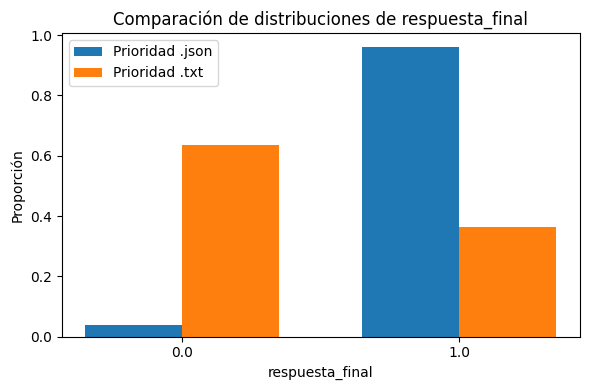

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Carga de los CSV generados
df_clas = pd.read_csv("data/diferencias_prioridad_clasificacion_interna.csv")
df_resp = pd.read_csv("data/diferencias_prioridad_response_group.csv")

# 2. Cómputo de distribuciones de 'respuesta_final'
counts_clas = df_clas['respuesta_final'].value_counts().sort_index()
counts_resp = df_resp['respuesta_final'].value_counts().sort_index()

# 3. Conversión a proporciones
props_clas = counts_clas / counts_clas.sum()
props_resp = counts_resp / counts_resp.sum()

# 4. DataFrame comparativo
df_comp = pd.DataFrame({
    'Prioridad Clas. Interna': props_clas,
    'Prioridad Response Group': props_resp
}).fillna(0)

# 5. Gráfico de barras lado a lado
labels = df_comp.index.tolist()
x = range(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(6,4))
ax.bar([i - width/2 for i in x], df_comp['Prioridad Clas. Interna'], width, label='Prioridad .json')
ax.bar([i + width/2 for i in x], df_comp['Prioridad Response Group'], width, label='Prioridad .txt')

ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_xlabel('respuesta_final')
ax.set_ylabel('Proporción')
ax.set_title('Comparación de distribuciones de respuesta_final')
ax.legend()
plt.tight_layout()
plt.show()


In [2]:
import pandas as pd
# Cargar matriz de expresión génica
expr_path = "data/TCGA.BRCA.sampleMap_HiSeqV2/HiSeqV2"
expr = pd.read_csv(expr_path, sep="\t", index_col=0)

# Transponer: muestras como filas, genes como columnas
expr = expr.T

# limpieza
expr.index = expr.index.str.strip()

In [3]:

# Cargar etiquetas refinadas
labels = pd.read_csv("data/diferencias_prioridad_response_group.csv")

# Estandarizar IDs base (sin sufijo A/B/C)
labels["sample_id"] = labels["submitter_id.samples"].str[:-1]

# Filtrar los válidos
expr_filtered = expr.loc[expr.index.isin(labels["sample_id"])]
labels_filtered = labels[labels["sample_id"].isin(expr_filtered.index)]

In [4]:
# Merge usando sample_id
merged = expr_filtered.merge(labels_filtered, left_index=True, right_on="sample_id")

In [5]:

# Columnas meta que no son genes
metadata_cols = [
    "submitter_id.samples", "recibio_quimio", "disease_response_final",
    "clasificacion_interna", "response_group", "clas_int_num",
    "respuesta_final", "sample_id"
]
# Separar features y etiquetas
X = merged.drop(columns=[c for c in metadata_cols if c in merged.columns])

y = merged["respuesta_final"]

In [ ]:

# Guardar CSV con todo
merged.to_csv("data/TCGA_BRCA_expression_with_labels.csv", index=False)

# Verificación
print("✅ Listo")
print("X shape:", X.shape)
print("y shape:", y.shape)


✅ Listo
X shape: (498, 20530)
y shape: (498,)


In [9]:
# guardar archivo CSV para test

# Cargar etiquetas refinadas
labels = pd.read_csv("data/BRCA_sin_respuesta_final.csv")

# Estandarizar IDs base (sin sufijo A/B/C)
labels["sample_id"] = labels["submitter_id.samples"].str[:-1]

# Filtrar los válidos
expr_filtered = expr.loc[expr.index.isin(labels["sample_id"])]
labels_filtered = labels[labels["sample_id"].isin(expr_filtered.index)]

In [10]:
# Merge usando sample_id
merged = expr_filtered.merge(labels_filtered, left_index=True, right_on="sample_id")

In [11]:

# Columnas meta que no son genes
metadata_cols = [
    "submitter_id.samples", "recibio_quimio", "disease_response_final",
    "clasificacion_interna", "response_group",
    "respuesta_final", "sample_id"
]
# Separar features y etiquetas
X_test = merged.drop(columns=[c for c in metadata_cols if c in merged.columns])

In [12]:

# Guardar CSV con todo
merged.to_csv("data/TCGA_BRCA_expression_test.csv", index=False)

# Verificación
print("✅ Listo")
print("X shape:", X_test.shape)

✅ Listo
X shape: (537, 20530)


La **Desviación Absoluta Mediana (MAD)** de una variable $X$ se define como:

$$
\mathrm{MAD}(X) = \mathrm{median}\bigl(\,\bigl|X_i - \mathrm{median}(X)\bigr|\bigr)
$$

donde:

* $\mathrm{median}(X)$ es la mediana de todos los valores $X_i$.
* $\bigl|X_i - \mathrm{median}(X)\bigr|$ es la distancia absoluta de cada valor a la mediana.
* A esa lista de distancias se le aplica de nuevo la mediana.

MAD mide la dispersión de los datos usando distancias absolutas respecto al punto central (la mediana), siendo robusto ante valores extremos.


In [13]:
# Selección de genes y escalado (top 20% MAD + Min–Max)
medianas = X.median(axis=0)
mad = ((X - medianas).abs()).median(axis=0)

# Filtrar top 20% genes por MAD
n_top = int(len(mad) * 0.2)
top_genes = mad.sort_values(ascending=False).iloc[:n_top].index
X_filt = X[top_genes]
X_test_filt = X_test[top_genes]

In [14]:

from sklearn.preprocessing import MinMaxScaler

# 5. Normalización Min–Max
scaler = MinMaxScaler()
X_scaled = pd.DataFrame(
    scaler.fit_transform(X_filt),
    index=X_filt.index,
    columns=X_filt.columns
)
X_test_scaled = pd.DataFrame(
    scaler.fit_transform(X_test_filt),
    index=X_test_filt.index,
    columns=X_test_filt.columns
)

In [15]:
# 6. Guardar y verificar
X_scaled.to_csv("data/X_scaled_top20pct_genes.csv", index=True)
X_test_scaled.to_csv("data/X_test_scaled_top20pct_genes.csv", index=True)
pd.Series(y.values, index=y.index).to_csv("data/y_labels.csv", index=True)

print("✔ MAD calculado y top20% genes seleccionados:")
print("Total genes:", X.shape[1])
print("Genes filtrados:", X_filt.shape[1])
print("X_scaled shape:", X_scaled.shape)
print("y shape:", y.shape)

✔ MAD calculado y top20% genes seleccionados:
Total genes: 20530
Genes filtrados: 4106
X_scaled shape: (498, 4106)
y shape: (498,)


In [16]:
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim

In [28]:
# Implementación de VAE en PyTorch

# Carga de datos
X = pd.read_csv("data/X_scaled_top20pct_genes.csv", index_col=0)
X_tensor = torch.tensor(X.values, dtype=torch.float32)
dataset = TensorDataset(X_tensor)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Arquitectura VAE
def build_linear_layers(sizes, activation=nn.ReLU):
    layers = []
    for i in range(len(sizes) - 1):
        layers.append(nn.Linear(sizes[i], sizes[i + 1]))
        if i < len(sizes) - 2:
            layers.append(activation())
    return nn.Sequential(*layers)

class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim=50, hidden_dims=[512, 256, 128]):
        super(VAE, self).__init__()
        self.encoder = build_linear_layers([input_dim] + hidden_dims, activation=nn.ReLU)
        self.fc_mu = nn.Linear(hidden_dims[-1], latent_dim)
        self.fc_logvar = nn.Linear(hidden_dims[-1], latent_dim)

        hidden_dims.reverse()
        self.decoder_input = nn.Linear(latent_dim, hidden_dims[-1])
        self.decoder = build_linear_layers(hidden_dims[::-1] + [input_dim], activation=nn.ReLU)

    def encode(self, x):
        h = self.encoder(x)
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = self.decoder_input(z)
        return self.decoder(h)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon = self.decode(z)
        return recon, mu, logvar

# Función de pérdida
def loss_function(recon_x, x, mu, logvar):
    recon_loss = nn.L1Loss(reduction='sum')(recon_x, x)
    kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kld

# Entrenamiento con EarlyStopping
def train_vae(X_tensor, input_dim, latent_dim=50, hidden_dims=[512, 256, 128],
              epochs=200, patience=15, model_path="vae_best_model.pt"):
    model = VAE(input_dim=input_dim, latent_dim=latent_dim, hidden_dims=hidden_dims).to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    best_loss = float('inf')
    epochs_no_improve = 0

    for epoch in range(1, epochs + 1):
        model.train()
        total_loss = 0

        for batch in DataLoader(TensorDataset(X_tensor), batch_size=64, shuffle=True):
            data = batch[0].to(device)
            optimizer.zero_grad()
            recon_batch, mu, logvar = model(data)
            loss = loss_function(recon_batch, data, mu, logvar)
            loss.backward()
            total_loss += loss.item()
            optimizer.step()

        avg_loss = total_loss / len(X_tensor)
        print(f"Epoch {epoch}, Loss: {avg_loss:.4f}")

        # Early stopping
        if avg_loss < best_loss - 1e-4:
            best_loss = avg_loss
            torch.save(model.state_dict(), model_path)
            print("🔽 Nueva mejor pérdida. Modelo guardado.")
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print("🛑 Early stopping.")
                break

    print(f"✅ Entrenamiento finalizado. Mejor pérdida: {best_loss:.4f}")
    return model

# Entrenar el modelo
input_dim = X.shape[1]
X_tensor = X_tensor.to(device)
vae = train_vae(X_tensor, input_dim=input_dim, latent_dim=50, epochs=200, patience=10)

# Cargar mejor modelo entrenado
vae.load_state_dict(torch.load("vae_best_model.pt"))
vae.eval()

# Extraer embeddings
with torch.no_grad():
    mu, _ = vae.encode(X_tensor)
embeddings = mu.cpu().numpy()
pd.DataFrame(embeddings, index=X.index).to_csv("data/vae_embeddings_v2.csv")
print("💾 Embeddings guardados en vae_embeddings.csv")

Epoch 1, Loss: 1560.6985
🔽 Nueva mejor pérdida. Modelo guardado.
Epoch 2, Loss: 955.3658
🔽 Nueva mejor pérdida. Modelo guardado.
Epoch 3, Loss: 705.0226
🔽 Nueva mejor pérdida. Modelo guardado.
Epoch 4, Loss: 661.4224
🔽 Nueva mejor pérdida. Modelo guardado.
Epoch 5, Loss: 639.2854
🔽 Nueva mejor pérdida. Modelo guardado.
Epoch 6, Loss: 627.3900
🔽 Nueva mejor pérdida. Modelo guardado.
Epoch 7, Loss: 619.2450
🔽 Nueva mejor pérdida. Modelo guardado.
Epoch 8, Loss: 612.5062
🔽 Nueva mejor pérdida. Modelo guardado.
Epoch 9, Loss: 606.8982
🔽 Nueva mejor pérdida. Modelo guardado.
Epoch 10, Loss: 603.8154
🔽 Nueva mejor pérdida. Modelo guardado.
Epoch 11, Loss: 603.6565
🔽 Nueva mejor pérdida. Modelo guardado.
Epoch 12, Loss: 601.1523
🔽 Nueva mejor pérdida. Modelo guardado.
Epoch 13, Loss: 602.3343
Epoch 14, Loss: 600.0927
🔽 Nueva mejor pérdida. Modelo guardado.
Epoch 15, Loss: 595.8199
🔽 Nueva mejor pérdida. Modelo guardado.
Epoch 16, Loss: 592.2662
🔽 Nueva mejor pérdida. Modelo guardado.
Epoch 17

/tmp/ipykernel_10337/137613486.py:102: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vae.load_state_dict(torch.load("vae_best_model.pt"))


In [29]:
# Implementación de VAE en PyTorch para test

# Carga de datos
X = pd.read_csv("data/X_test_scaled_top20pct_genes.csv", index_col=0)
X_tensor = torch.tensor(X.values, dtype=torch.float32)
dataset = TensorDataset(X_tensor)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Arquitectura VAE
def build_linear_layers(sizes, activation=nn.ReLU):
    layers = []
    for i in range(len(sizes) - 1):
        layers.append(nn.Linear(sizes[i], sizes[i + 1]))
        if i < len(sizes) - 2:
            layers.append(activation())
    return nn.Sequential(*layers)

class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim=50, hidden_dims=[512, 256, 128]):
        super(VAE, self).__init__()
        self.encoder = build_linear_layers([input_dim] + hidden_dims, activation=nn.ReLU)
        self.fc_mu = nn.Linear(hidden_dims[-1], latent_dim)
        self.fc_logvar = nn.Linear(hidden_dims[-1], latent_dim)

        hidden_dims.reverse()
        self.decoder_input = nn.Linear(latent_dim, hidden_dims[-1])
        self.decoder = build_linear_layers(hidden_dims[::-1] + [input_dim], activation=nn.ReLU)

    def encode(self, x):
        h = self.encoder(x)
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = self.decoder_input(z)
        return self.decoder(h)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon = self.decode(z)
        return recon, mu, logvar

# Función de pérdida
def loss_function(recon_x, x, mu, logvar):
    recon_loss = nn.L1Loss(reduction='sum')(recon_x, x)
    kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kld

# Entrenamiento con EarlyStopping
def train_vae(X_tensor, input_dim, latent_dim=50, hidden_dims=[512, 256, 128],
              epochs=200, patience=15, model_path="vae_best_model_test.pt"):
    model = VAE(input_dim=input_dim, latent_dim=latent_dim, hidden_dims=hidden_dims).to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    best_loss = float('inf')
    epochs_no_improve = 0

    for epoch in range(1, epochs + 1):
        model.train()
        total_loss = 0

        for batch in DataLoader(TensorDataset(X_tensor), batch_size=64, shuffle=True):
            data = batch[0].to(device)
            optimizer.zero_grad()
            recon_batch, mu, logvar = model(data)
            loss = loss_function(recon_batch, data, mu, logvar)
            loss.backward()
            total_loss += loss.item()
            optimizer.step()

        avg_loss = total_loss / len(X_tensor)
        print(f"Epoch {epoch}, Loss: {avg_loss:.4f}")

        # Early stopping
        if avg_loss < best_loss - 1e-4:
            best_loss = avg_loss
            torch.save(model.state_dict(), model_path)
            print("🔽 Nueva mejor pérdida. Modelo guardado.")
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print("🛑 Early stopping.")
                break

    print(f"✅ Entrenamiento finalizado. Mejor pérdida: {best_loss:.4f}")
    return model

# Entrenar el modelo
input_dim = X.shape[1]
X_tensor = X_tensor.to(device)
vae = train_vae(X_tensor, input_dim=input_dim, latent_dim=50, epochs=200, patience=10)

# Cargar mejor modelo entrenado
vae.load_state_dict(torch.load("vae_best_model_test.pt"))
vae.eval()

# Extraer embeddings
with torch.no_grad():
    mu, _ = vae.encode(X_tensor)
embeddings = mu.cpu().numpy()
pd.DataFrame(embeddings, index=X.index).to_csv("data/vae_embeddings_test.csv")
print("💾 Embeddings guardados en vae_embeddings.csv")

Epoch 1, Loss: 1504.8622
🔽 Nueva mejor pérdida. Modelo guardado.
Epoch 2, Loss: 865.3488
🔽 Nueva mejor pérdida. Modelo guardado.
Epoch 3, Loss: 670.1161
🔽 Nueva mejor pérdida. Modelo guardado.
Epoch 4, Loss: 629.5431
🔽 Nueva mejor pérdida. Modelo guardado.
Epoch 5, Loss: 610.9513
🔽 Nueva mejor pérdida. Modelo guardado.
Epoch 6, Loss: 605.6290
🔽 Nueva mejor pérdida. Modelo guardado.
Epoch 7, Loss: 603.5574
🔽 Nueva mejor pérdida. Modelo guardado.
Epoch 8, Loss: 600.7068
🔽 Nueva mejor pérdida. Modelo guardado.
Epoch 9, Loss: 599.3518
🔽 Nueva mejor pérdida. Modelo guardado.
Epoch 10, Loss: 590.0933
🔽 Nueva mejor pérdida. Modelo guardado.
Epoch 11, Loss: 587.4307
🔽 Nueva mejor pérdida. Modelo guardado.
Epoch 12, Loss: 585.3484
🔽 Nueva mejor pérdida. Modelo guardado.
Epoch 13, Loss: 583.3430
🔽 Nueva mejor pérdida. Modelo guardado.
Epoch 14, Loss: 580.9163
🔽 Nueva mejor pérdida. Modelo guardado.
Epoch 15, Loss: 580.1956
🔽 Nueva mejor pérdida. Modelo guardado.
Epoch 16, Loss: 578.6251
🔽 Nueva 

/tmp/ipykernel_10337/2356613977.py:102: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vae.load_state_dict(torch.load("vae_best_model_test.pt"))
